In [8]:
import numpy as np
import matplotlib.pyplot as plt

from pyabc import *

settings.set_figure_params("pyabc")  # for beautified plots

rng = np.random.default_rng()

from simulations.elastic_collisions import (
    Body,
    Variables,
    ElasticCollisionSimulation,
    HiddenVariables,
)
import torch

# simulation parameters
total_time = 1.0
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
constant_mass_value = 1.0
constant_radius_value = max_radius
velocity_distribution = torch.distributions.Uniform(low=-5.0, high=5.0)
position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)
num_bodies = 1
VARIABLES = Variables(
    masses=torch.full((num_bodies,), constant_mass_value),
    radii=torch.full((num_bodies,), constant_radius_value),
    starting_positions=None,
    num_bodies=num_bodies,
    space_size=torch.tensor([space_size, space_size]),
    acceleration_coefficients=torch.Tensor([1.0] * num_bodies),
    initial_velocities=None,
)

initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(
    VARIABLES, position_distribution
)
VARIABLES.starting_positions = initial_positions
print(f"initial_positions: {initial_positions}")

initial_velocities = velocity_distribution.sample(
    sample_shape=torch.Size([num_bodies, 2])
)
print(f"initial_velocities: {initial_velocities}")

SIMULATION = ElasticCollisionSimulation(VARIABLES, enable_logging=False, noise=False)

hidden_variables = HiddenVariables(
    masses=None,
    radii=None,
    num_bodies=None,
    acceleration_coefficients=None,
    initial_velocities=initial_velocities,
)

result = SIMULATION.simulate(
    hidden_variables=hidden_variables, total_time=total_time, dt=dt
)

print(f"result: {result}")


def model(p):
    starting_velocities = torch.tensor(
        [[p["X0"], p["Y0"]]], dtype=torch.float32
    )
    X_Obs = SIMULATION.simulate(
        hidden_variables=HiddenVariables(
            masses=VARIABLES.masses,
            radii=VARIABLES.radii,
            num_bodies=VARIABLES.num_bodies,
            acceleration_coefficients=None,
            initial_velocities=starting_velocities,
        ),
        total_time=total_time,
        dt=dt,
    )
    # convert to numpy array
    X_Obs = X_Obs.detach().numpy()
    return {"X_Obs": X_Obs}


# true parameters
true_parameters = {
    "X0": initial_velocities[0, 0].item(),
    "Y0": initial_velocities[0, 1].item(),
}

# prior
prior = Distribution(
    X0=RV("uniform", -5, 5),
    Y0=RV("uniform", -5, 5),
)

# observed data
# X_Obs = result.detach().numpy()
# without np
X_Obs = {"X_Obs": result.detach().numpy()}


# distance function
def distance(x, y):
    return np.linalg.norm(x["X_Obs"] - y["X_Obs"])


# parameter bounds
prior_bounds = {
    "X0": (-5, 5),
    "Y0": (-5, 5),
}




initial_positions: tensor([[1.4125, 6.5092]])
initial_velocities: tensor([[-0.7936, -3.7281]])
result: tensor([[1.2538, 2.7811]])


In [11]:
# ABCSMC
abc = ABCSMC(model, prior, distance, population_size=1000)
abc.new(create_sqlite_db_id(), X_Obs)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 24 processes.
ABC.History INFO: Start <ABCSMC id=66, start_time=2024-03-20 21:51:31>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 1.70177042e+00.
ABC INFO: Accepted: 1000 / 2021 = 4.9480e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 1.10119110e+00.
ABC INFO: Accepted: 1000 / 3381 = 2.9577e-01, ESS: 8.1300e+02.
ABC INFO: t: 2, eps: 6.93508830e-01.
ABC INFO: Accepted: 1000 / 5941 = 1.6832e-01, ESS: 6.7553e+02.
ABC INFO: t: 3, eps: 4.55566148e-01.
ABC INFO: Accepted: 1000 / 10301 = 9.7078e-02, ESS: 7.6352e+02.
ABC INFO: t: 4, eps: 2.97517430e-01.
ABC INFO: Accepted: 1000 / 19965 = 5.0088e-02, ESS: 8.3954e+02.
ABC INFO: t: 5, eps: 2.05597922e-01.
ABC INFO: Accepted: 1000 / 32797 = 3.0491e-02, ESS: 2.7355e+01.
ABC INFO: t: 6, eps: 1.64821279e-01.
ABC INFO: Accepted: 1000 / 65588 = 1.5247e-02, ESS: 6.4276e+02.
ABC INFO: t: 7, eps: 1.18352915e-01.
ABC INFO: Accepted: 1000 / 112606 = 8.8805e-03, ESS: 7.6408e+02.
ABC INFO: t: 8, eps: 8.3800672

ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.7625}


array([[<Axes: ylabel='X0'>, <Axes: >],
       [<Axes: xlabel='X0', ylabel='Y0'>, <Axes: xlabel='Y0'>]],
      dtype=object)

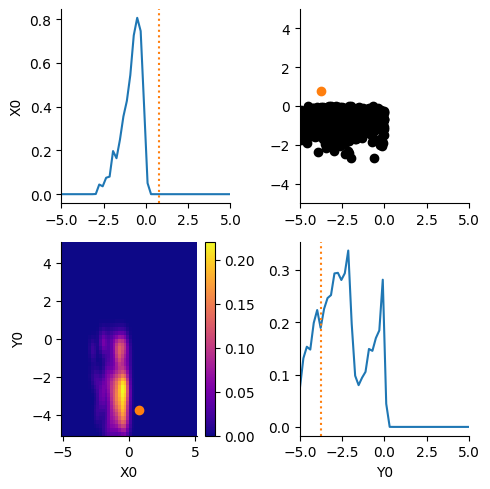

In [14]:
# visualize results
visualization.plot_kde_matrix_highlevel(
    history,
    limits=prior_bounds,
    refval=true_parameters,
    kde=GridSearchCV(),
)

<Axes: xlabel='X0', ylabel='Y0'>

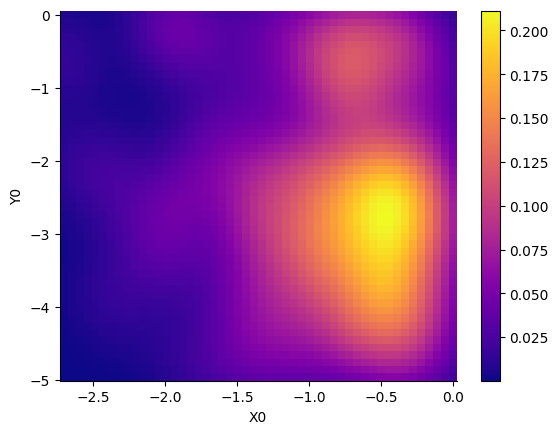

In [19]:
# visualize results
visualization.plot_kde_2d_highlevel(
    history,
    x="X0",
    y="Y0",
)

<Axes: xlabel='X0', ylabel='Posterior'>

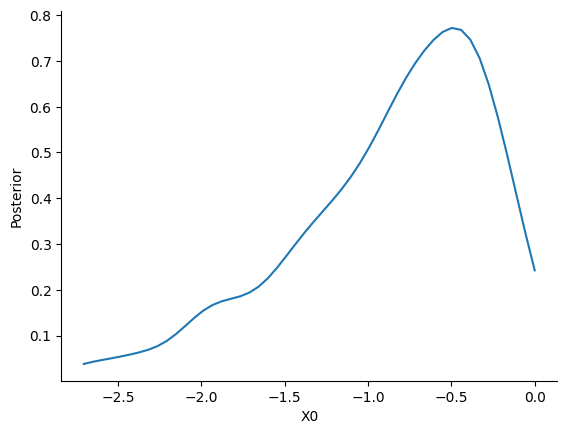

In [20]:
visualization.plot_kde_1d_highlevel(
    history,
    x="X0",
)

## With 2 bodies:

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from pyabc import *

settings.set_figure_params("pyabc")  # for beautified plots

rng = np.random.default_rng()

from simulations.elastic_collisions import (
    Body,
    Variables,
    ElasticCollisionSimulation,
    HiddenVariables,
)
import torch

# simulation parameters
total_time = 1.0
dt = 0.1
space_size = 10.0
max_radius = space_size // 10.0
constant_mass_value = 1.0
constant_radius_value = max_radius
velocity_distribution = torch.distributions.Uniform(low=-5.0, high=5.0)
position_distribution = torch.distributions.Uniform(low=0.0, high=space_size)
num_bodies = 2
VARIABLES = Variables(
    masses=torch.full((num_bodies,), constant_mass_value),
    radii=torch.full((num_bodies,), constant_radius_value),
    starting_positions=None,
    num_bodies=num_bodies,
    space_size=torch.tensor([space_size, space_size]),
    acceleration_coefficients=torch.Tensor([1.0] * num_bodies),
    initial_velocities=None,
)

initial_positions = ElasticCollisionSimulation.sample_initial_positions_without_overlap(
    VARIABLES, position_distribution
)
VARIABLES.starting_positions = initial_positions
print(f"initial_positions: {initial_positions}")

initial_velocities = velocity_distribution.sample(
    sample_shape=torch.Size([num_bodies, 2])
)
print(f"initial_velocities: {initial_velocities}")

SIMULATION = ElasticCollisionSimulation(VARIABLES, enable_logging=False, noise=False)

hidden_variables = HiddenVariables(
    masses=None,
    radii=None,
    num_bodies=None,
    acceleration_coefficients=None,
    initial_velocities=initial_velocities,
)

result = SIMULATION.simulate(
    hidden_variables=hidden_variables, total_time=total_time, dt=dt
)

print(f"result: {result}")


def model(p):
    starting_velocities = torch.tensor(
        [[p["X0"], p["Y0"]], [p["X1"], p["Y1"]]], dtype=torch.float32
    )
    X_Obs = SIMULATION.simulate(
        hidden_variables=HiddenVariables(
            masses=VARIABLES.masses,
            radii=VARIABLES.radii,
            num_bodies=VARIABLES.num_bodies,
            acceleration_coefficients=None,
            initial_velocities=starting_velocities,
        ),
        total_time=total_time,
        dt=dt,
    )
    # convert to numpy array
    X_Obs = X_Obs.detach().numpy()
    return {"X_Obs": X_Obs}


# true parameters
true_parameters = {
    "X0": initial_velocities[0, 0].item(),
    "Y0": initial_velocities[0, 1].item(),
    "X1": initial_velocities[1, 0].item(),
    "Y1": initial_velocities[1, 1].item(),
}

# prior
prior = Distribution(
    X0=RV("uniform", -5, 5),
    Y0=RV("uniform", -5, 5),
    X1=RV("uniform", -5, 5),
    Y1=RV("uniform", -5, 5),
)

# observed data
# X_Obs = result.detach().numpy()
# without np
X_Obs = {"X_Obs": result.detach().numpy()}


# distance function
def distance(x, y):
    return np.linalg.norm(x["X_Obs"] - y["X_Obs"])


# parameter bounds
prior_bounds = {
    "X0": (-5, 5),
    "Y0": (-5, 5),
    "X1": (-5, 5),
    "Y1": (-5, 5),
}

initial_positions: tensor([[2.5323, 2.4448],
        [3.1130, 5.7108]])
initial_velocities: tensor([[ 1.5514, -4.2065],
        [ 4.5316,  3.7074]])
result: tensor([[4.0837, 3.2861],
        [7.6446, 8.6767]])


In [22]:
# ABCSMC
abc = ABCSMC(model, prior, distance, population_size=1000)
abc.new(create_sqlite_db_id(), X_Obs)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=10)

ABC.Sampler INFO: Parallelize sampling on 24 processes.
ABC.History INFO: Start <ABCSMC id=67, start_time=2024-03-20 22:02:32>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 8.82775784e+00.
ABC INFO: Accepted: 1000 / 2373 = 4.2141e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 7.77616310e+00.
ABC INFO: Accepted: 1000 / 6315 = 1.5835e-01, ESS: 8.0406e+02.
ABC INFO: t: 2, eps: 7.04431324e+00.
ABC INFO: Accepted: 1000 / 9569 = 1.0450e-01, ESS: 7.4839e+02.
ABC INFO: t: 3, eps: 6.40234710e+00.
ABC INFO: Accepted: 1000 / 14675 = 6.8143e-02, ESS: 7.0933e+02.
ABC INFO: t: 4, eps: 5.82542371e+00.
ABC INFO: Accepted: 1000 / 39702 = 2.5188e-02, ESS: 7.5160e+02.
ABC INFO: t: 5, eps: 5.41431817e+00.
ABC INFO: Accepted: 1000 / 53720 = 1.8615e-02, ESS: 6.6634e+02.
ABC INFO: t: 6, eps: 5.03797520e+00.
ABC INFO: Accepted: 1000 / 57737 = 1.7320e-02, ESS: 6.8964e+00.
ABC INFO: t: 7, eps: 4.89303286e+00.
ABC INFO: Accepted: 1000 / 171683 = 5.8247e-03, ESS: 6.4329e+02.
ABC INFO: t: 8, eps: 4.4493315

ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.05}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.2875}
ABC.Transition INFO: Best params: {'scaling': 0.2875}


array([[<Axes: ylabel='X0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='X1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='Y0'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='X0', ylabel='Y1'>, <Axes: xlabel='X1'>,
        <Axes: xlabel='Y0'>, <Axes: xlabel='Y1'>]], dtype=object)

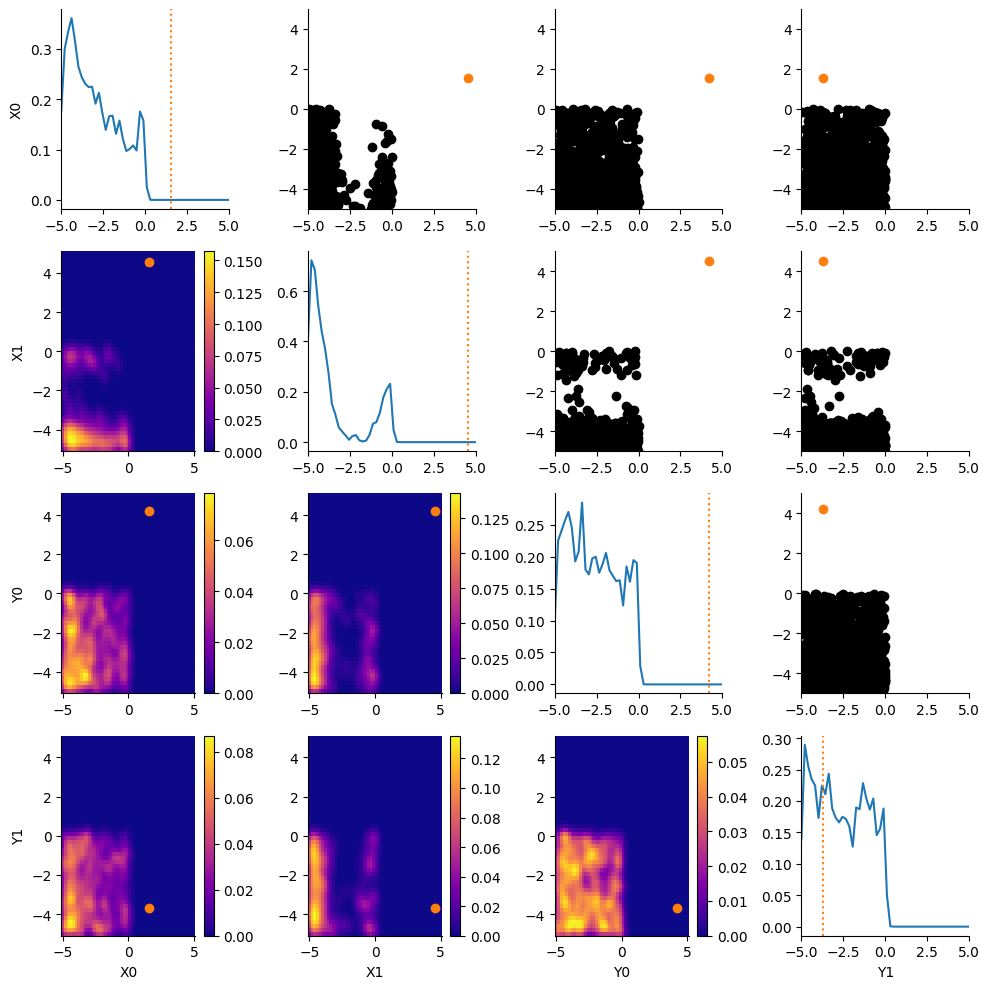

In [23]:
# visualize results
visualization.plot_kde_matrix_highlevel(
    history,
    limits=prior_bounds,
    refval=true_parameters,
    kde=GridSearchCV(),
)

<Axes: xlabel='X0', ylabel='Y0'>

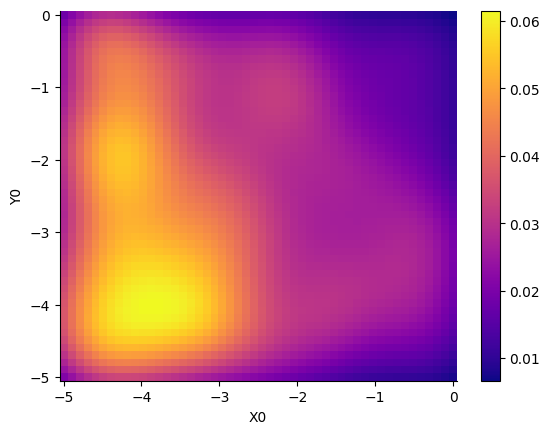

In [24]:
# visualize results of X0 and Y0
visualization.plot_kde_2d_highlevel(
    history,
    x="X0",
    y="Y0",
)

<Axes: xlabel='X1', ylabel='Y1'>

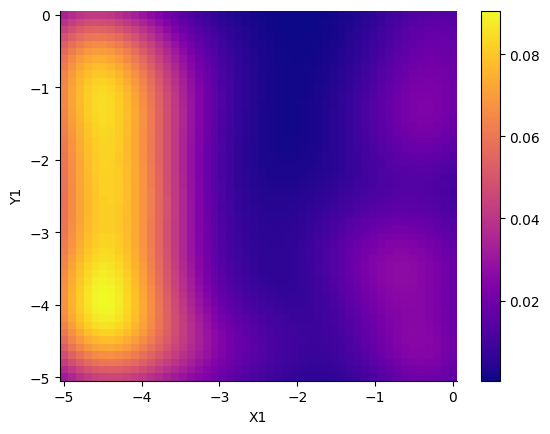

In [25]:
# visualize results of X1 and Y1
visualization.plot_kde_2d_highlevel(
    history,
    x="X1",
    y="Y1",
)

In [26]:
# More iterations
# ABCSMC
abc = ABCSMC(model, prior, distance, population_size=1000)
abc.new(create_sqlite_db_id(), X_Obs)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100)

ABC.Sampler INFO: Parallelize sampling on 24 processes.
ABC.History INFO: Start <ABCSMC id=68, start_time=2024-03-20 22:10:30>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 8.93213224e+00.
ABC INFO: Accepted: 1000 / 2222 = 4.5005e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 7.79307961e+00.
ABC INFO: Accepted: 1000 / 5115 = 1.9550e-01, ESS: 7.8591e+02.
ABC INFO: t: 2, eps: 6.98485145e+00.
ABC INFO: Accepted: 1000 / 10420 = 9.5969e-02, ESS: 5.6481e+01.
ABC INFO: t: 3, eps: 6.18284525e+00.
ABC INFO: Accepted: 1000 / 27669 = 3.6142e-02, ESS: 7.9650e+02.
ABC INFO: t: 4, eps: 5.73092691e+00.
ABC INFO: Accepted: 1000 / 30947 = 3.2313e-02, ESS: 6.0013e+02.
ABC INFO: t: 5, eps: 5.32178850e+00.
ABC INFO: Accepted: 1000 / 61395 = 1.6288e-02, ESS: 5.9800e+02.
ABC INFO: t: 6, eps: 4.92369869e+00.
ABC INFO: Accepted: 1000 / 78049 = 1.2812e-02, ESS: 6.7148e+02.
ABC INFO: t: 7, eps: 4.46850833e+00.
ABC INFO: Accepted: 1000 / 271705 = 3.6805e-03, ESS: 5.4035e+02.
ABC INFO: t: 8, eps: 4.224166